In [70]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from tensorflow.keras.applications import vgg16, vgg19

import wandb
from wandb.keras import WandbCallback

In [71]:
def seed_everything():
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
    np.random.seed(hash("improves reproducibility") % 2**32 - 1)
    tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)
    
seed_everything()

In [72]:

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}
# Loops through pathlist and reads and resizes images
def read_image(pathlist : list, size : int)-> list:
    data = []
    for path in pathlist:
        image=load_img(path, color_mode='rgb', target_size=(size, size))
        image=img_to_array(image)
        # image=image/255.0
        data.append(image)
    return data

# Makes input and label data from folder locations.
# Loops through location "subfolder/CLASSES"
def get_sets(subfolder : str, CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"2_split_{v}/{subfolder}").rglob("*"))
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

def get_training_set(CLASSES : dict, size : int) -> tuple[list, list]:
    folder_paths = []
    folder_labels = []
    labels = []
    for k,v in CLASSES.items():
        # input datapath generation
        folder_paths += list((datapath / f"3_aug_{v}_train/").rglob("*"))
        # print(folder_paths)
    # Label data generation
    folder_labels = [0 if x.stem.split('_')[1] == 'yes' else 1 for x in folder_paths]
    # Extract images from datapaths
    img_list = read_image(folder_paths, size)

    return img_list, folder_labels

# Dataset inspect
# Read images to variables
size = 224
# X_train, y_train = get_training_set(CLASSES, size)
X_train, y_train = get_sets('train', CLASSES, size)
X_val, y_val = get_sets('val', CLASSES, size)
X_test, y_test = get_sets('test', CLASSES, size)

In [73]:
base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
base_model.trainable = False

In [74]:
from keras import Model
import keras
from keras.layers import Dense, Flatten, Dropout, Input, GlobalAveragePooling2D

from keras.callbacks import ModelCheckpoint


inputs = Input(shape=(X_train[0].shape[0], X_train[0].shape[1], 3))
x = vgg19.preprocess_input(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

In [75]:
checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [76]:


wand_run  = wandb.init(project="baseline_vgg16", entity="bex_team", group=base_model._name.upper(), job_type="Baseline",
           config={"learning_rate" : 0.001,
                   "epochs": 50,
                   "batch_size": 30,
                   "architecture" : f"{base_model._name.upper()} global_average_pooling2d",
                   "dataset" : "Brain MRI Images for Brain Tumor Detection",
                   })

config = wandb.config
# wandb.log({"model_summary" : model.summary(), "base_model_summary" : base_model.summary()})


In [77]:
metrics = ['accuracy']

tf.keras.backend.clear_session()

opt = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)#learning_rate=0.0006)
# opt = tf.keras.optimizers.ad(learning_rate=0.00015)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=metrics)

callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val),np.array(y_val)), epochs=config.epochs, batch_size=config.batch_size, verbose=2, callbacks=[callbacks, model_checkpoint_callback, WandbCallback(data_type='image', training_data=(np.array(X_val),np.array(y_val)), labels=CLASSES, save_model=True, save_graph=True)])



# trained_model_artifact = wandb.Artifact(config.architecture, type="model", description="baseline flatten for vgg16")
# trained_model_artifact.add_dir(checkpoint_filepath.parent)
# wand_run.log_artifact(trained_model_artifact)


wand_run.finish()

Epoch 1/50
5/5 - 6s - loss: 1.4179 - accuracy: 0.4240 - val_loss: 0.9792 - val_accuracy: 0.5714 - 6s/epoch - 1s/step
Epoch 2/50
5/5 - 4s - loss: 1.2735 - accuracy: 0.5840 - val_loss: 0.9879 - val_accuracy: 0.6190 - 4s/epoch - 753ms/step
Epoch 3/50
5/5 - 5s - loss: 1.1401 - accuracy: 0.5840 - val_loss: 0.7734 - val_accuracy: 0.6429 - 5s/epoch - 950ms/step
Epoch 4/50
5/5 - 3s - loss: 0.9445 - accuracy: 0.5280 - val_loss: 0.7458 - val_accuracy: 0.6190 - 3s/epoch - 576ms/step
Epoch 5/50
5/5 - 3s - loss: 0.8637 - accuracy: 0.5600 - val_loss: 0.7048 - val_accuracy: 0.6429 - 3s/epoch - 548ms/step
Epoch 6/50
5/5 - 5s - loss: 0.7783 - accuracy: 0.6160 - val_loss: 0.6905 - val_accuracy: 0.6667 - 5s/epoch - 942ms/step
Epoch 7/50
5/5 - 5s - loss: 0.7060 - accuracy: 0.6800 - val_loss: 0.6434 - val_accuracy: 0.6905 - 5s/epoch - 915ms/step
Epoch 8/50
5/5 - 5s - loss: 0.6433 - accuracy: 0.6960 - val_loss: 0.6279 - val_accuracy: 0.7143 - 5s/epoch - 956ms/step
Epoch 9/50
5/5 - 6s - loss: 0.5982 - accura

accuracy,▁▃▃▂▃▄▄▅▅▅▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▂▃▃▄▄▄▄▅▅▅▄▆▆▅▅▇▇█▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▆
val_loss,██▅▅▅▄▄▄▃▃▃▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▂
accuracy,0.968
best_epoch,47
best_val_loss,0.38872
epoch,49
loss,0.15969
val_accuracy,0.83333


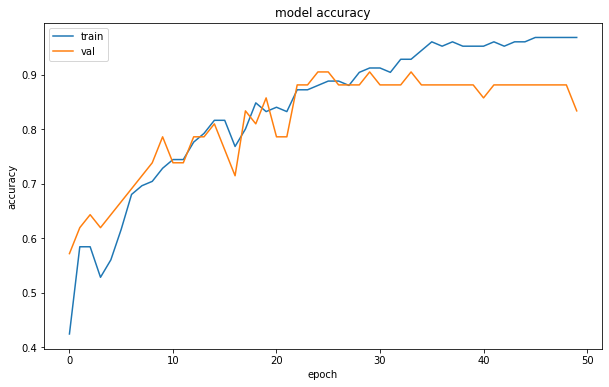

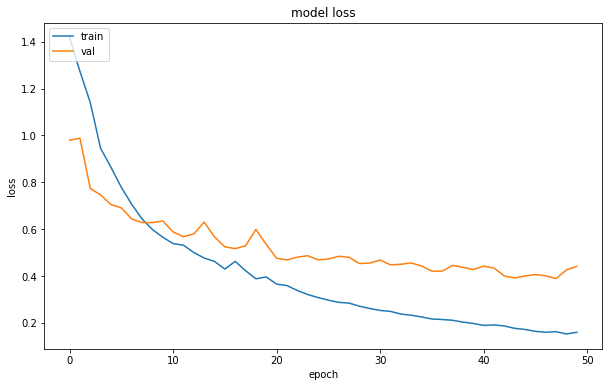

In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
CLASS_NAMES = ['yes', 'no']


plt.figure(figsize = (10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize = (10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

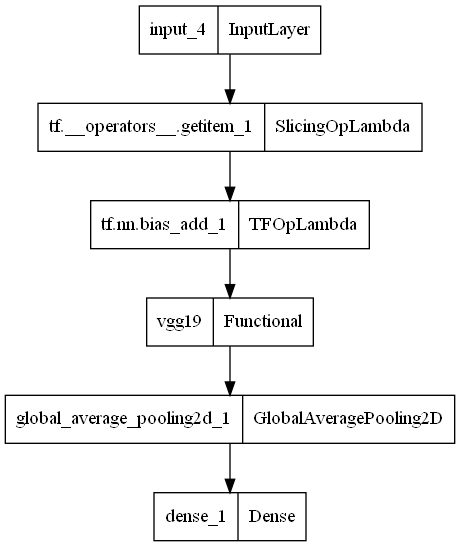

In [79]:
tf.keras.utils.plot_model(model)